In [2]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [4]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

In [5]:
# Load data
train = pd.read_csv('../public_data_test/track_a/train/eng.csv')
val = pd.read_csv('../public_data_test/track_a/dev/eng.csv')
test = pd.read_csv('../public_data_test/track_a/test/eng.csv')

# Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [6]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [7]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [8]:
emolex_path = "../NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [9]:
def load_emolex(emolex_path):
    emolex = pd.read_csv(emolex_path, sep='\t', header=None, names=["Word", "Emotion", "Association"])
    # Filter to only include our target emotions
    emolex = emolex[emolex['Emotion'].isin(emotions)]
    
    emotion_dict = {}
    for _, row in emolex.iterrows():
        if row["Association"] == 1:  # Only positive associations
            word = row["Word"].lower()  # Convert to lowercase
            emotion = row["Emotion"].lower()
            if word not in emotion_dict:
                emotion_dict[word] = []
            emotion_dict[word].append(emotion)
    
    print(f"Loaded {len(emotion_dict)} words from EmoLex")
    return emotion_dict

emotion_dict = load_emolex(emolex_path)

Loaded 3155 words from EmoLex


In [10]:
nlp = spacy.load("en_core_web_sm")

# Initialize emotion_matches globally before preprocessing
emotion_matches = {emotion: 0 for emotion in emotions}

for emotion in emotions:
    emotion_words = [word for word, emots in emotion_dict.items() if emotion in emots]
    print(f"\n{emotion} words in lexicon: {len(emotion_words)}")
    print("Sample words:", emotion_words[:5])

# During preprocessing
def pre_process(text, config, target_emotion, emotion_dict):
    global emotion_matches  # Reference the global variable
    
    original_text = text  # Save original text for EmoLex matching

    # First do EmoLex matching on original text
    emolex_words = []
    if target_emotion and emotion_dict:
        # Convert text to lowercase for matching
        text_lower = original_text.lower()
        # Find words that appear in both text and emotion lexicon
        text_words = set(text_lower.split())
        emolex_words = [word for word in text_words 
                       if word in emotion_dict 
                       and target_emotion in emotion_dict[word]]
        
        if emolex_words:
            emotion_matches[target_emotion] += 1

    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    processed_text = " ".join(tokens)

    # Finally, append EmoLex words if found
    if emolex_words:
        processed_text = f"{processed_text} [SEP] {' '.join(emolex_words)}"
    else:
        processed_text = f"{processed_text} [SEP]"
    
    return processed_text

# After preprocessing
# print("\nEmotion word matches in training data:")
# for emotion in emotions:
#     print(f"{emotion}: {emotion_matches[emotion]} texts")


joy words in lexicon: 687
Sample words: ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment']

sadness words in lexicon: 1187
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abortion']

surprise words in lexicon: 532
Sample words: ['abandonment', 'abduction', 'abrupt', 'accident', 'accidental']

fear words in lexicon: 1474
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abhor']

anger words in lexicon: 1245
Sample words: ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish']


In [11]:
# Vectorizer Definition
vectorizer = CountVectorizer()

In [12]:
# Reset emotion_matches before processing dataset
def preprocess_dataset_with_emotions(dataset, emotions, config, emotion_dict):
    global emotion_matches
    emotion_matches = {emotion: 0 for emotion in emotions}  # Reset counters
    
    augmented_data = {}
    
    # Process for each emotion
    for emotion in emotions:
        print(f"\nProcessing {emotion}:")
        texts = []
        for text in tqdm(dataset):
            processed = pre_process(text, config, target_emotion=emotion, emotion_dict=emotion_dict)
            texts.append(processed)
            
        # Count how many texts contain emotion-specific words
        emotion_word_count = sum(1 for text in texts if '[SEP]' in text and not text.endswith('[SEP]'))
        print(f"Texts with {emotion}-specific words: {emotion_matches[emotion]}/{len(texts)}")
        
        augmented_data[emotion] = texts
    
    return augmented_data

train_augmented = preprocess_dataset_with_emotions(train["text"], emotions, config, emotion_dict)
val_augmented = preprocess_dataset_with_emotions(val["text"], emotions, config, emotion_dict)
test_augmented = preprocess_dataset_with_emotions(test["text"], emotions, config, emotion_dict)

# Fit the vectorizer on the combined training data
vectorizer = CountVectorizer()
vectorizer.fit(train_augmented['joy'] + train_augmented['sadness'] + train_augmented['surprise'] + train_augmented['fear'] + train_augmented['anger'])

# Transform each emotion separately
X_train = {emotion: vectorizer.transform(train_augmented[emotion]).toarray() for emotion in emotions}
X_val = {emotion: vectorizer.transform(val_augmented[emotion]).toarray() for emotion in emotions}
X_test = {emotion: vectorizer.transform(test_augmented[emotion]).toarray() for emotion in emotions}


Processing joy:


100%|██████████| 2768/2768 [00:04<00:00, 667.40it/s] 


Texts with joy-specific words: 461/2768

Processing sadness:


100%|██████████| 2768/2768 [00:01<00:00, 1837.90it/s]


Texts with sadness-specific words: 569/2768

Processing surprise:


100%|██████████| 2768/2768 [00:01<00:00, 1752.00it/s]


Texts with surprise-specific words: 318/2768

Processing fear:


100%|██████████| 2768/2768 [00:01<00:00, 1793.84it/s]


Texts with fear-specific words: 520/2768

Processing anger:


100%|██████████| 2768/2768 [00:01<00:00, 1898.75it/s]


Texts with anger-specific words: 463/2768

Processing joy:


100%|██████████| 116/116 [00:00<00:00, 1792.53it/s]


Texts with joy-specific words: 19/116

Processing sadness:


100%|██████████| 116/116 [00:00<00:00, 1903.38it/s]


Texts with sadness-specific words: 22/116

Processing surprise:


100%|██████████| 116/116 [00:00<00:00, 1901.64it/s]


Texts with surprise-specific words: 15/116

Processing fear:


100%|██████████| 116/116 [00:00<00:00, 1995.88it/s]


Texts with fear-specific words: 21/116

Processing anger:


100%|██████████| 116/116 [00:00<00:00, 1955.98it/s]


Texts with anger-specific words: 17/116

Processing joy:


100%|██████████| 2767/2767 [00:01<00:00, 1521.52it/s]


Texts with joy-specific words: 453/2767

Processing sadness:


100%|██████████| 2767/2767 [00:01<00:00, 1538.65it/s]


Texts with sadness-specific words: 537/2767

Processing surprise:


100%|██████████| 2767/2767 [00:01<00:00, 1727.08it/s]


Texts with surprise-specific words: 349/2767

Processing fear:


100%|██████████| 2767/2767 [00:01<00:00, 1861.92it/s]


Texts with fear-specific words: 531/2767

Processing anger:


100%|██████████| 2767/2767 [00:01<00:00, 1638.90it/s]


Texts with anger-specific words: 438/2767


In [13]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu
/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [14]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [16]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [15]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [17]:
# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

In [18]:
# Get BERT embeddings for training data
print("Getting training BERT embeddings...")
train_raw_preds = get_predictions_batch(train['text'].tolist())
train_bert_features = format_predictions(train_raw_preds, emotion_mapping)

print("Getting validation BERT embeddings...")
val_raw_preds = get_predictions_batch(val['text'].tolist())
val_bert_features = format_predictions(val_raw_preds, emotion_mapping)

print("Getting test BERT embeddings...")
test_raw_preds = get_predictions_batch(test['text'].tolist())
test_bert_features = format_predictions(test_raw_preds, emotion_mapping)

# Get POS features
print("Extracting POS features...")
train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])
test_pos_tags = extract_pos_tags(test["text"])

# POS Encoding
max_length = max(
    max(len(tags) for tags in train_pos_tags),
    max(len(tags) for tags in val_pos_tags),
    max(len(tags) for tags in test_pos_tags)
)
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]
test_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in test_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)
test_pos_encoded = encoder.transform(test_pos_tags)

Getting training BERT embeddings...


Predicting: 100%|██████████| 87/87 [06:03<00:00,  4.18s/it]


Getting validation BERT embeddings...


Predicting: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Getting test BERT embeddings...


Predicting: 100%|██████████| 87/87 [06:04<00:00,  4.19s/it]


Extracting POS features...


In [19]:
for emotion in emotions:
    print(f"Emotion: {emotion}")
    print(f"Train Vectorizer Shape: {X_train[emotion].shape}")
    print(f"Val Vectorizer Shape: {X_val[emotion].shape}")
    print(f"Train BERT Shape: {train_bert_features.shape}")
    print(f"Val BERT Shape: {val_bert_features.shape}")
    print(f"Train POS Shape: {train_pos_encoded.shape}")
    print(f"Val POS Shape: {val_pos_encoded.shape}")

Emotion: joy
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: sadness
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: surprise
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: fear
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: anger
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)


In [20]:
# Combine features for each emotion separately
final_train_features = {}
final_val_features = {}
final_test_features = {}

print("Combining features for each emotion...")
for emotion in emotions:
    print(f"\nProcessing {emotion}:")
    print(f"X_train shape: {X_train[emotion].shape}")
    print(f"train_bert_features shape: {train_bert_features.shape}")
    print(f"train_pos_encoded shape: {train_pos_encoded.shape}")
    
    final_train_features[emotion] = np.hstack([
        X_train[emotion],
        train_bert_features,
        train_pos_encoded
    ])
    
    final_val_features[emotion] = np.hstack([
        X_val[emotion],
        val_bert_features,
        val_pos_encoded
    ])
    
    final_test_features[emotion] = np.hstack([
        X_test[emotion],
        test_bert_features,
        test_pos_encoded
    ])
    
    print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

Combining features for each emotion...

Processing joy:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for joy: (2768, 5521)

Processing sadness:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for sadness: (2768, 5521)

Processing surprise:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for surprise: (2768, 5521)

Processing fear:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for fear: (2768, 5521)

Processing anger:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for anger: (2768, 5521)


In [21]:
# Create a model for each emotion
models = {}
for emotion in emotions:
    input_size = final_train_features[emotion].shape[1]  # Get the feature size for each emotion
    models[emotion] = nn.Sequential(
        nn.Linear(input_size, 256),  # Use the correct input size
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

In [22]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [23]:
for emotion in emotions:

    print(f"Feature size for {emotion}: {final_train_features[emotion].shape[1]}")

Feature size for joy: 5521
Feature size for sadness: 5521
Feature size for surprise: 5521
Feature size for fear: 5521
Feature size for anger: 5521


/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for joy
Validation features shape for joy: torch.Size([116, 5521])


Training Loop (joy):   0%|          | 1/401 [00:00<03:55,  1.70it/s]


Epoch 0 (joy):
Training Loss: 0.9430, Validation Loss: 0.8549
Macro F1: 0.7442

New best model for joy at epoch 0 with F1: 0.7442


Training Loop (joy):   2%|▏         | 10/401 [00:12<08:14,  1.27s/it]


Epoch 10 (joy):
Training Loss: 0.0456, Validation Loss: 2.4577
Macro F1: 0.6628

Early stopping triggered at epoch 10

Loaded best model for joy from epoch 0 with F1: 0.7442



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/3040162064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

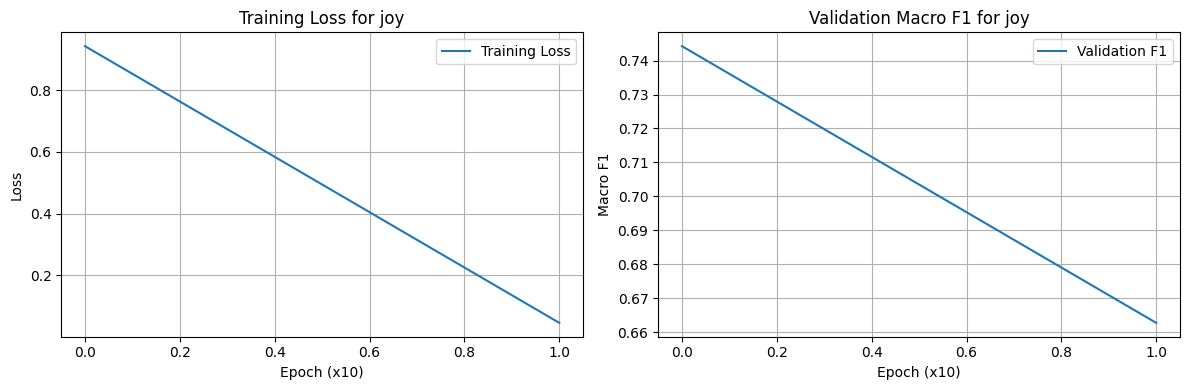

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for sadness
Validation features shape for sadness: torch.Size([116, 5521])


Training Loop (sadness):   0%|          | 1/401 [00:01<09:28,  1.42s/it]


Epoch 0 (sadness):
Training Loss: 0.9103, Validation Loss: 0.7528
Macro F1: 0.7139

New best model for sadness at epoch 0 with F1: 0.7139


Training Loop (sadness):   1%|          | 4/401 [00:05<10:31,  1.59s/it]


New best model for sadness at epoch 3 with F1: 0.7527


Training Loop (sadness):   2%|▏         | 10/401 [00:13<08:13,  1.26s/it]


New best model for sadness at epoch 9 with F1: 0.7583


Training Loop (sadness):   3%|▎         | 11/401 [00:15<08:12,  1.26s/it]


Epoch 10 (sadness):
Training Loss: 0.0832, Validation Loss: 1.2235
Macro F1: 0.6489


Training Loop (sadness):   5%|▍         | 19/401 [00:28<09:42,  1.52s/it]


Early stopping triggered at epoch 19

Loaded best model for sadness from epoch 9 with F1: 0.7583



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/3040162064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

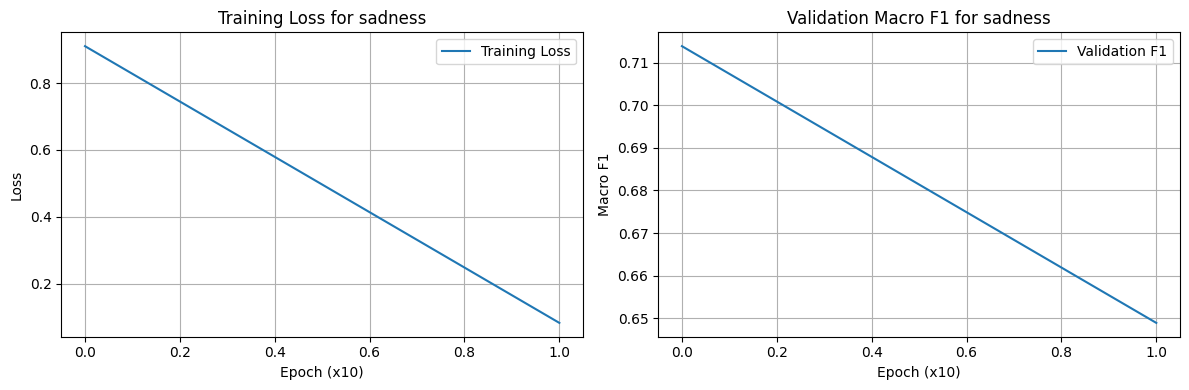

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for surprise
Validation features shape for surprise: torch.Size([116, 5521])


Training Loop (surprise):   0%|          | 1/401 [00:01<06:58,  1.05s/it]


Epoch 0 (surprise):
Training Loss: 0.8461, Validation Loss: 0.6971
Macro F1: 0.6987

New best model for surprise at epoch 0 with F1: 0.6987


Training Loop (surprise):   1%|          | 4/401 [00:04<07:13,  1.09s/it]


New best model for surprise at epoch 3 with F1: 0.7104


Training Loop (surprise):   3%|▎         | 11/401 [00:12<07:29,  1.15s/it]


Epoch 10 (surprise):
Training Loss: 0.0716, Validation Loss: 1.5640
Macro F1: 0.6448


Training Loop (surprise):   3%|▎         | 13/401 [00:16<08:10,  1.27s/it]


Early stopping triggered at epoch 13

Loaded best model for surprise from epoch 3 with F1: 0.7104



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/3040162064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

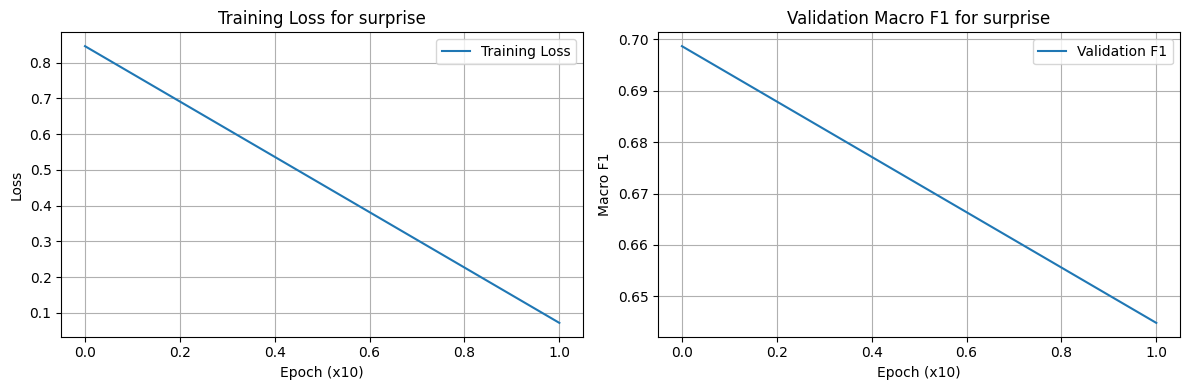

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for fear
Validation features shape for fear: torch.Size([116, 5521])


Training Loop (fear):   0%|          | 1/401 [00:01<08:12,  1.23s/it]


Epoch 0 (fear):
Training Loss: 0.5370, Validation Loss: 0.5242
Macro F1: 0.6375

New best model for fear at epoch 0 with F1: 0.6375


Training Loop (fear):   0%|          | 2/401 [00:02<08:20,  1.25s/it]


New best model for fear at epoch 1 with F1: 0.6444


Training Loop (fear):   1%|          | 4/401 [00:04<07:36,  1.15s/it]


New best model for fear at epoch 3 with F1: 0.6485


Training Loop (fear):   2%|▏         | 9/401 [00:10<07:38,  1.17s/it]


New best model for fear at epoch 8 with F1: 0.6626


Training Loop (fear):   3%|▎         | 11/401 [00:12<07:10,  1.10s/it]


Epoch 10 (fear):
Training Loss: 0.0620, Validation Loss: 0.9979
Macro F1: 0.6280


Training Loop (fear):   3%|▎         | 13/401 [00:14<07:12,  1.12s/it]


New best model for fear at epoch 12 with F1: 0.6881


Training Loop (fear):   5%|▌         | 21/401 [00:23<06:39,  1.05s/it]


Epoch 20 (fear):
Training Loss: 0.0166, Validation Loss: 1.3895
Macro F1: 0.6290


Training Loop (fear):   5%|▌         | 22/401 [00:25<07:13,  1.14s/it]


Early stopping triggered at epoch 22

Loaded best model for fear from epoch 12 with F1: 0.6881



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/3040162064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

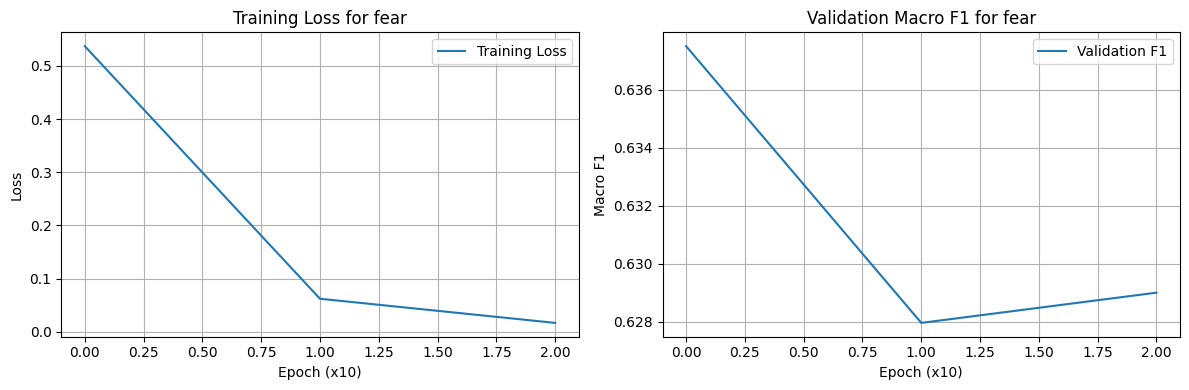

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for anger
Validation features shape for anger: torch.Size([116, 5521])


Training Loop (anger):   0%|          | 1/401 [00:00<05:23,  1.24it/s]


Epoch 0 (anger):
Training Loss: 1.1692, Validation Loss: 1.1481
Macro F1: 0.6356

New best model for anger at epoch 0 with F1: 0.6356


Training Loop (anger):   0%|          | 2/401 [00:02<09:47,  1.47s/it]


New best model for anger at epoch 1 with F1: 0.6383


Training Loop (anger):   1%|          | 5/401 [00:08<11:18,  1.71s/it]


New best model for anger at epoch 4 with F1: 0.6803


Training Loop (anger):   2%|▏         | 10/401 [00:15<09:11,  1.41s/it]


New best model for anger at epoch 9 with F1: 0.6898


Training Loop (anger):   3%|▎         | 11/401 [00:16<08:13,  1.27s/it]


Epoch 10 (anger):
Training Loss: 0.0957, Validation Loss: 2.3003
Macro F1: 0.6712


Training Loop (anger):   3%|▎         | 12/401 [00:17<07:57,  1.23s/it]


New best model for anger at epoch 11 with F1: 0.6945


Training Loop (anger):   3%|▎         | 13/401 [00:18<07:36,  1.18s/it]


New best model for anger at epoch 12 with F1: 0.6997


Training Loop (anger):   5%|▌         | 21/401 [00:25<06:07,  1.03it/s]


Epoch 20 (anger):
Training Loss: 0.0384, Validation Loss: 3.3281
Macro F1: 0.6650


Training Loop (anger):   6%|▌         | 23/401 [00:27<06:01,  1.05it/s]


New best model for anger at epoch 22 with F1: 0.7044


Training Loop (anger):   8%|▊         | 31/401 [00:37<07:36,  1.23s/it]


Epoch 30 (anger):
Training Loss: 0.0180, Validation Loss: 3.7307
Macro F1: 0.6189


Training Loop (anger):   8%|▊         | 32/401 [00:39<07:40,  1.25s/it]


Early stopping triggered at epoch 32



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/3040162064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint


Loaded best model for anger from epoch 22 with F1: 0.7044


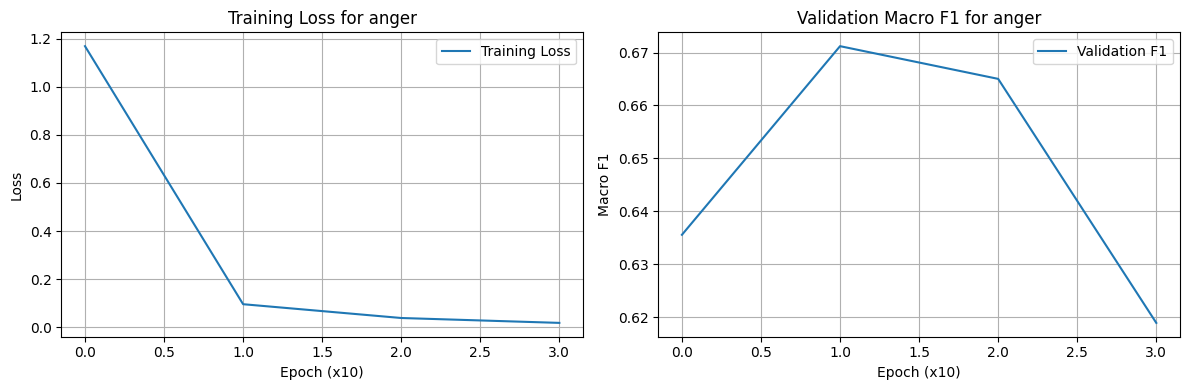

In [24]:
# Training loop for each emotion
for emotion in emotions:
    print(f"\nTraining model for {emotion}")
    model = models[emotion]
    model.train()  # Add this to explicitly set training mode
    
    # Prepare data for this emotion
    features_tensor = torch.tensor(final_train_features[emotion], dtype=torch.float32)
    labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    
    # Add validation tensors
    val_features_tensor = torch.tensor(final_val_features[emotion], dtype=torch.float32)
    val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    print(f"Validation features shape for {emotion}: {val_features_tensor.shape}")
    
    dataset = TensorDataset(features_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Increased batch size

    # Calculate class weights for this emotion
    pos_weight = (len(labels_tensor) - labels_tensor.sum()) / labels_tensor.sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Better handling of class imbalance
    
    # Use Adam optimizer with learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Training loop
    best_f1 = 0
    patience = 10
    patience_counter = 0
    train_losses = []
    val_f1s = []
    
    for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for features, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_preds = (torch.sigmoid(val_outputs).squeeze() > 0.5).float()
            val_labels = val_labels_tensor.squeeze()
            
            # Calculate metrics
            val_loss = criterion(val_outputs, val_labels_tensor)
            macro_f1 = f1_score(
                val_labels.cpu().numpy(),
                val_preds.cpu().numpy(),
                average='macro',
                zero_division=0
            )

        # Learning rate scheduling
        scheduler.step(macro_f1)

        if epoch % 10 == 0:  # More frequent logging
            print(f'\nEpoch {epoch} ({emotion}):')
            print(f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Macro F1: {macro_f1:.4f}')
            train_losses.append(avg_train_loss)
            val_f1s.append(macro_f1)
        
        # Save best model
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'f1': macro_f1
            }, f'./model_checkpoints/{emotion}_best.pth')
            print(f"\nNew best model for {emotion} at epoch {epoch} with F1: {macro_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Load best model for this emotion
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model for {emotion} from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.title(f'Training Loss for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
    plt.title(f'Validation Macro F1 for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Macro F1')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Complete same training loop for all emotions using macro F1 score

In [25]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')


Generating predictions for all emotions...
Using best joy model from epoch 0 with F1: 0.744
Using best sadness model from epoch 9 with F1: 0.758


/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2104/118298516.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoints/

Using best surprise model from epoch 3 with F1: 0.710
Using best fear model from epoch 12 with F1: 0.688
Using best anger model from epoch 22 with F1: 0.704

Performing threshold grid search for joy...


Testing thresholds for joy: 100%|██████████| 16/16 [00:00<00:00, 56.48it/s]



Best Results for joy:
Best threshold: 0.500
Best Macro F1: 0.623


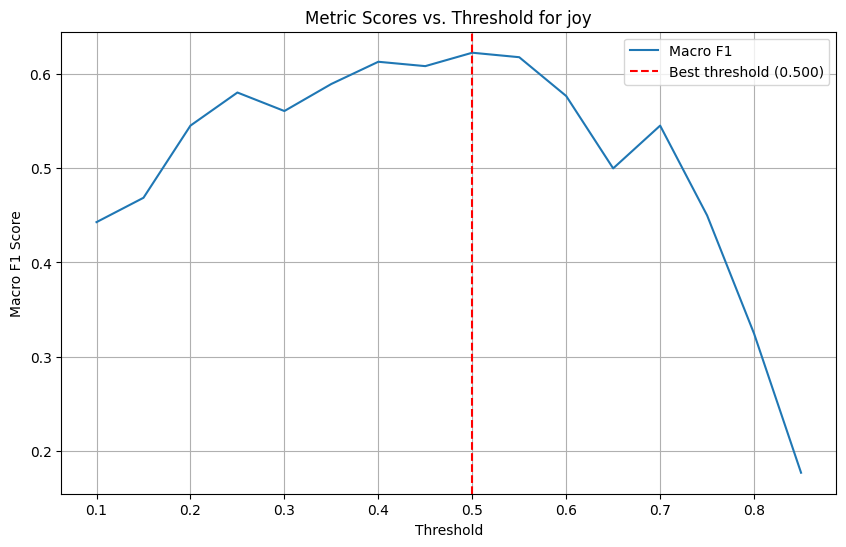


Performing threshold grid search for sadness...


Testing thresholds for sadness: 100%|██████████| 16/16 [00:00<00:00, 422.30it/s]


Best Results for sadness:
Best threshold: 0.600
Best Macro F1: 0.676


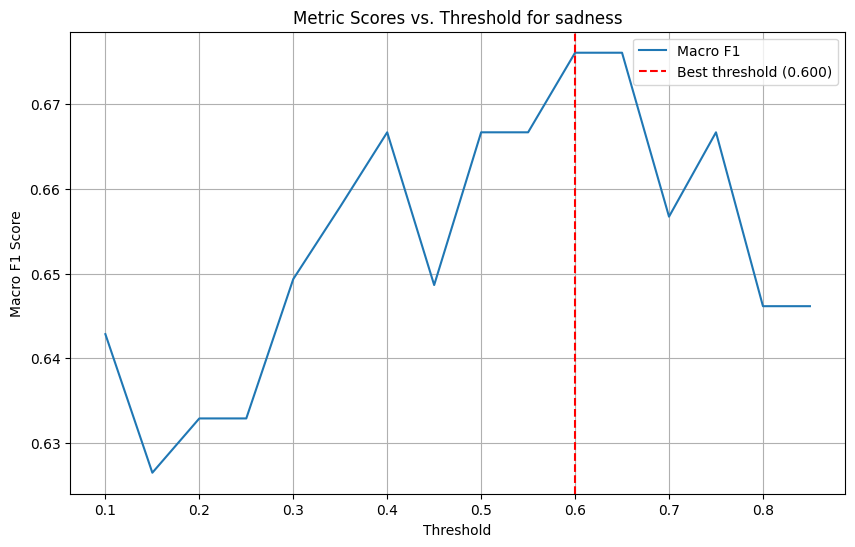


Performing threshold grid search for surprise...


Testing thresholds for surprise: 100%|██████████| 16/16 [00:00<00:00, 664.35it/s]


Best Results for surprise:
Best threshold: 0.250
Best Macro F1: 0.647


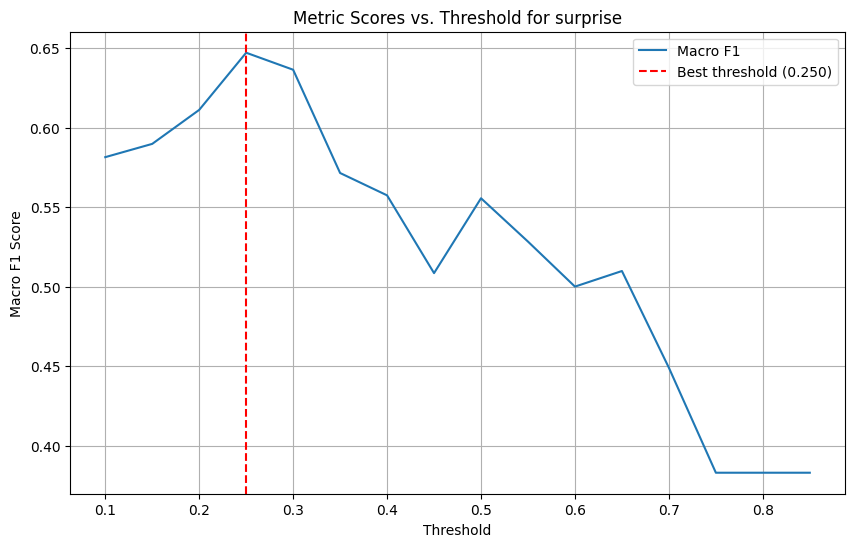


Performing threshold grid search for fear...


Testing thresholds for fear: 100%|██████████| 16/16 [00:00<00:00, 671.62it/s]


Best Results for fear:
Best threshold: 0.300
Best Macro F1: 0.754


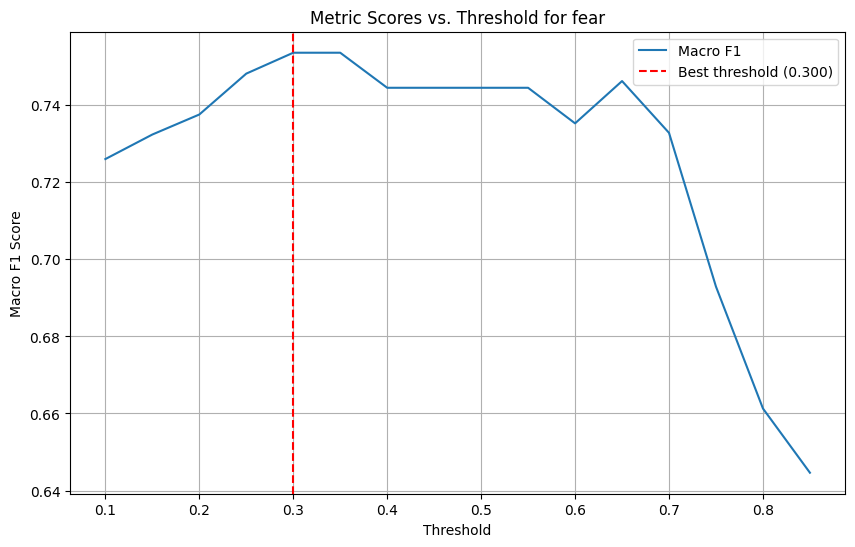


Performing threshold grid search for anger...


Testing thresholds for anger: 100%|██████████| 16/16 [00:00<00:00, 216.72it/s]


Best Results for anger:
Best threshold: 0.350
Best Macro F1: 0.516


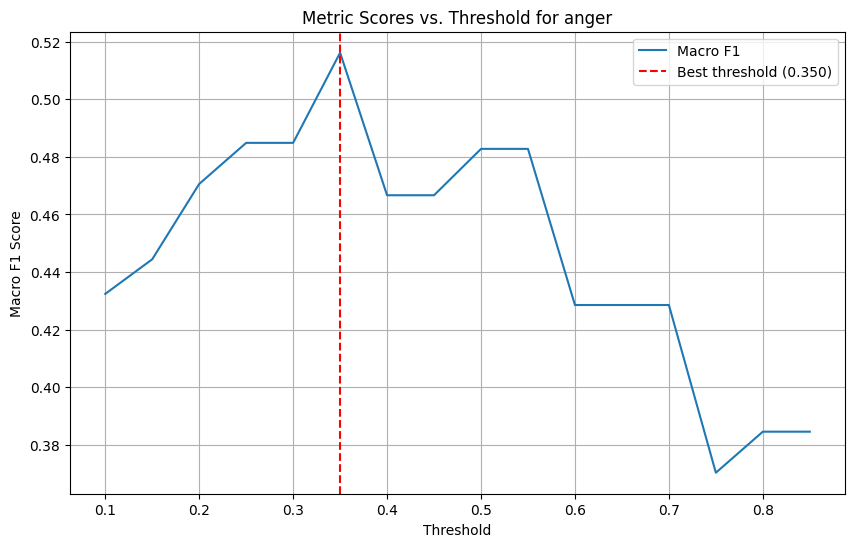


Final Validation Performance with Best Thresholds:
              precision    recall  f1-score   support

         joy       0.63      0.61      0.62        31
     sadness       0.67      0.69      0.68        35
    surprise       0.59      0.71      0.65        31
        fear       0.69      0.83      0.75        63
       anger       0.53      0.50      0.52        16

   micro avg       0.65      0.71      0.68       176
   macro avg       0.62      0.67      0.64       176
weighted avg       0.65      0.71      0.67       176
 samples avg       0.62      0.65      0.60       176

Saved predictions to ../results/val_predictions_dynamic_thresholds_2025-02-17_11_57_08.csv
Saved predictions to ../results/test_predictions_dynamic_thresholds_2025-02-17_11_57_08.csv

Per-emotion performance at best thresholds:
joy: F1 = 0.623
sadness: F1 = 0.676
surprise: F1 = 0.647
fear: F1 = 0.754
anger: F1 = 0.516


/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# After training loop finishes for all emotions...

# Make predictions for each emotion using best models
print("\nGenerating predictions for all emotions...")
val_preds = {}
test_preds = {}

for emotion in emotions:
    # Load the best model for this emotion
    model = models[emotion]
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"Using best {emotion} model from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.3f}")
    
    with torch.no_grad():
        # Get raw probabilities using sigmoid
        val_outputs = model(torch.tensor(final_val_features[emotion], dtype=torch.float32))
        val_probs = torch.sigmoid(val_outputs).numpy()
        val_preds[emotion] = val_probs
        
        test_outputs = model(torch.tensor(final_test_features[emotion], dtype=torch.float32))
        test_probs = torch.sigmoid(test_outputs).numpy()
        test_preds[emotion] = test_probs

# Combine predictions
val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# Initialize a dictionary to store the best threshold for each emotion
best_thresholds = {emotion: 0 for emotion in emotions}
best_macro_f1s = {emotion: 0 for emotion in emotions}

# Perform threshold grid search for each emotion
for i, emotion in enumerate(emotions):
    print(f"\nPerforming threshold grid search for {emotion}...")
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in tqdm(thresholds, desc=f"Testing thresholds for {emotion}"):
        # Convert probabilities to binary predictions for this emotion
        val_binary_preds = (val_probs[:, i] > threshold).astype(int)
        
        # Calculate metrics
        macro_f1 = f1_score(val[emotions].values[:, i], val_binary_preds, average='binary')
        
        results.append({
            'threshold': threshold,
            'macro_f1': macro_f1
        })
        
        # Update best threshold if we found better macro F1
        if macro_f1 > best_macro_f1s[emotion]:
            best_macro_f1s[emotion] = macro_f1
            best_thresholds[emotion] = threshold

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results)
    print(f"\nBest Results for {emotion}:")
    print(f"Best threshold: {best_thresholds[emotion]:.3f}")
    print(f"Best Macro F1: {best_macro_f1s[emotion]:.3f}")

    # Plot the threshold search results for this emotion
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
    plt.axvline(x=best_thresholds[emotion], color='r', linestyle='--', label=f'Best threshold ({best_thresholds[emotion]:.3f})')
    plt.xlabel('Threshold')
    plt.ylabel('Macro F1 Score')
    plt.title(f'Metric Scores vs. Threshold for {emotion}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate final predictions using best thresholds for each emotion
val_binary_preds = np.zeros_like(val_probs, dtype=int)
test_binary_preds = np.zeros_like(test_probs, dtype=int)

for i, emotion in enumerate(emotions):
    val_binary_preds[:, i] = (val_probs[:, i] > best_thresholds[emotion]).astype(int)
    test_binary_preds[:, i] = (test_probs[:, i] > best_thresholds[emotion]).astype(int)

# Print detailed performance report
print("\nFinal Validation Performance with Best Thresholds:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions
))

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

# Save validation predictions
save_predictions(
    val_binary_preds,
    val['id'],
    f'../results/val_predictions_dynamic_thresholds_{timestamp}.csv'
)

# Save test predictions
save_predictions(
    test_binary_preds,
    test['id'],
    f'../results/test_predictions_dynamic_thresholds_{timestamp}.csv'
)

# Save threshold search results
results_df.to_csv(f'../results/threshold_search_results_dynamic_{timestamp}.csv', index=False)

# Print per-emotion performance
print("\nPer-emotion performance at best thresholds:")
for i, emotion in enumerate(emotions):
    emotion_f1 = f1_score(
        val[emotions].values[:, i],
        val_binary_preds[:, i],
        average='binary'
    )
    print(f"{emotion}: F1 = {emotion_f1:.3f}")


Performing threshold grid search for joy...


Testing thresholds for joy: 100%|██████████| 16/16 [00:00<00:00, 485.48it/s]



Best Results for joy:
Best threshold: 0.500
Best Macro F1: 0.623

Performing threshold grid search for sadness...


Testing thresholds for sadness: 100%|██████████| 16/16 [00:00<00:00, 721.47it/s]



Best Results for sadness:
Best threshold: 0.600
Best Macro F1: 0.676

Performing threshold grid search for surprise...


Testing thresholds for surprise: 100%|██████████| 16/16 [00:00<00:00, 158.09it/s]



Best Results for surprise:
Best threshold: 0.250
Best Macro F1: 0.647

Performing threshold grid search for fear...


Testing thresholds for fear: 100%|██████████| 16/16 [00:00<00:00, 82.54it/s]



Best Results for fear:
Best threshold: 0.300
Best Macro F1: 0.754

Performing threshold grid search for anger...


Testing thresholds for anger: 100%|██████████| 16/16 [00:00<00:00, 402.52it/s]



Best Results for anger:
Best threshold: 0.350
Best Macro F1: 0.516


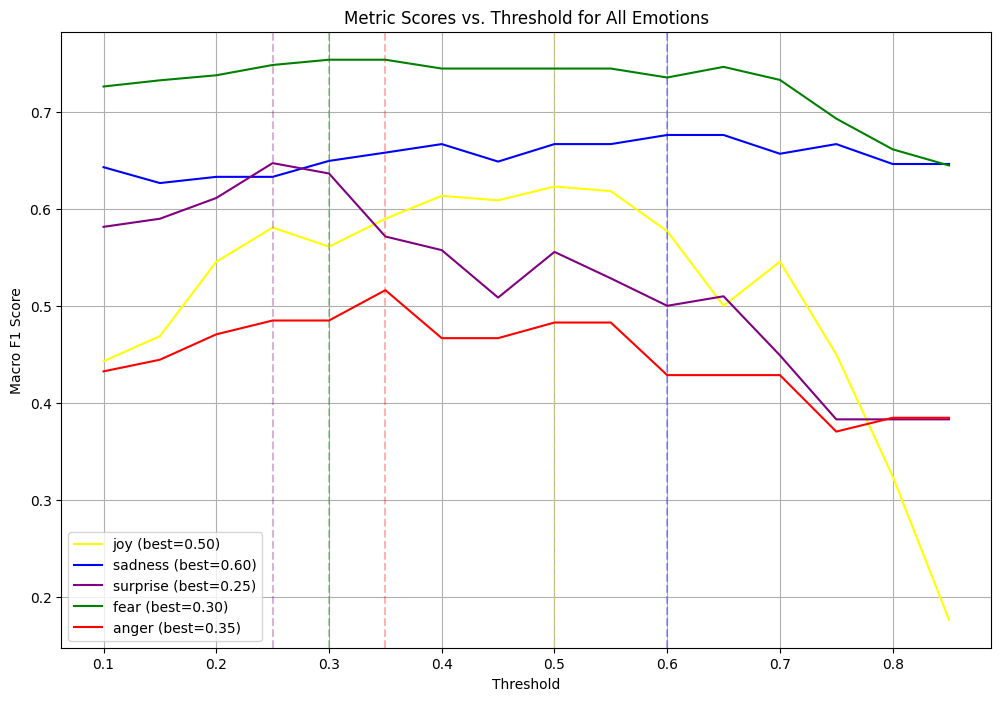

In [27]:
# Initialize a dictionary to store the best threshold for each emotion
best_thresholds = {emotion: 0 for emotion in emotions}
best_macro_f1s = {emotion: 0 for emotion in emotions}

# Create a single figure for all emotions
plt.figure(figsize=(12, 8))

# Define a color map for the emotions
color_map = {
    'joy': 'yellow',
    'sadness': 'blue',
    'surprise': 'purple',
    'fear': 'green',
    'anger': 'red'
}

# Perform threshold grid search for each emotion
for i, emotion in enumerate(emotions):
    print(f"\nPerforming threshold grid search for {emotion}...")
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in tqdm(thresholds, desc=f"Testing thresholds for {emotion}"):
        # Convert probabilities to binary predictions for this emotion
        val_binary_preds = (val_probs[:, i] > threshold).astype(int)
        
        # Calculate metrics
        macro_f1 = f1_score(val[emotions].values[:, i], val_binary_preds, average='binary')
        results.append({
            'threshold': threshold,
            'macro_f1': macro_f1
        })
        
        # Update best threshold if we found better macro F1
        if macro_f1 > best_macro_f1s[emotion]:
            best_macro_f1s[emotion] = macro_f1
            best_thresholds[emotion] = threshold

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Plot the line for this emotion
    plt.plot(results_df['threshold'], results_df['macro_f1'], 
             label=f'{emotion} (best={best_thresholds[emotion]:.2f})', 
             color=color_map[emotion])
    plt.axvline(x=best_thresholds[emotion], color=color_map[emotion], 
                linestyle='--', alpha=0.3)

    print(f"\nBest Results for {emotion}:")
    print(f"Best threshold: {best_thresholds[emotion]:.3f}")
    print(f"Best Macro F1: {best_macro_f1s[emotion]:.3f}")

plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')
plt.title('Metric Scores vs. Threshold for All Emotions')
plt.legend()
plt.grid(True)
plt.show()

# Continue with the rest of your existing code...

Scores for Test Set:

Evaluation scores for eng track a:

F1 score: micro=0.6199597841041379, macro=0.5523447943188394

Emotion-level macro F1 scores:
anger: 0.3597
fear: 0.7426
joy: 0.5248
sadness: 0.5489
surprise: 0.5857

END FOR NOW